# Assignment 2: CRF sequence tagging for Movie Queries

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

import nltk                                 # Natural language toolkit
from nltk.tokenize import word_tokenize     # seperates strings into words (along with punctuations getting seperated)

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
# Split the training data using the split percentage
def splitData(percentage):
    splitBorder   = int(percentage * len(raw_training_data))
    training_data = raw_training_data[0 : splitBorder]
    test_data     = raw_training_data[splitBorder : len(raw_training_data)]
    
    return training_data, test_data

# 4. Using POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

#### Report after making changes

In [4]:
def preProcess(text):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    
    #For loop to select the word from every tuple of the list and add a POS using the CRF POS tagger
    words = []
    for word_label in text:
        words.append(word_label[0])
        
    # a postagger - for tagging the part of speech to the word
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    word_pos_list = posttagger.tag(words)
    
    #concatenate the word and POS tag together (with a special symbol, e.g. @)
    token_biotag = []
    for idx, word_pos in enumerate(word_pos_list):
        word_posconcate_biotag = (word_pos[0] + '@' + word_pos[1],text[idx][1])
        token_biotag.append(word_posconcate_biotag)
    
    return token_biotag

In [5]:
#test to validate preProcess method
test = [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
preProcess(test)

[('what@WP', 'O'),
 ('movies@VBZ', 'O'),
 ('star@NNP', 'O'),
 ('bruce@NNP', 'B-ACTOR'),
 ('willis@NNP', 'I-ACTOR')]

In [6]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 
unprocessed_training_data = []
unprocessed_test_data = []
print("Now %d rawData, %d trainData, %d testData" % (len(raw_training_data), len(unprocessed_training_data), 
                                                     len(unprocessed_test_data)),
      "Preparing training and test data...",sep='\n')
unprocessed_training_data, unprocessed_test_data = splitData(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_training_data), len(unprocessed_training_data), 
       len(unprocessed_test_data)))

Now 9775 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 9775 rawData, 7820 trainData, 1955 testData


In [7]:
#Validate if the test data and train data got split correctly
print(unprocessed_training_data[0]) # first line of the engtrain.bio.txt
print(unprocessed_test_data[-1]) # last  line of the engtrain.bio.txt

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('i', 'O'), ('want', 'O'), ('to', 'O'), ('find', 'O'), ('the', 'O'), ('movie', 'O'), ('with', 'O'), ('scarlett', 'B-CHARACTER'), ('o', 'I-CHARACTER'), ('hara', 'I-CHARACTER'), ('in', 'O'), ('it', 'O')]


In [8]:
training_data = [preProcess(sample) for sample in unprocessed_training_data]

In [9]:
print(training_data[2])  #print third line of the processed training data

[('what@WP', 'O'), ('movies@NNS', 'O'), ('starred@VBD', 'O'), ('both@DT', 'O'), ('al@NNP', 'B-ACTOR'), ('pacino@NNP', 'I-ACTOR'), ('and@CC', 'O'), ('robert@NNP', 'B-ACTOR'), ('deniro@NNP', 'I-ACTOR')]


# 5. Feature experimentation for optimal macro average (20 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format. You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q1 and Q2 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes. Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `engtest.bio.txt`) as your final piece of code.

#### Briefly describe the method
- Step 1: Added suffixes upto length 4 and prefixes of length 4 and 5. This increased the f1-score of the macro average from 63% after adding the POS tags to 65%
- Step 2: Added the istitle() to identify the titles and islower() for lower case. The f1-score of the macro average remains the same
- Step 3: After the adding just features for the previous token(current-1) f1-score of the macro-average improved from 65% to 71%. 
- Step 4: After adding the next token features along with the previous(current+1), the f1-score of macro average to 70% is reached
- Step 5: Added the previous token(current-2) features along with the next(current+2), the f1-score of macro average remains constant at 70%
- step 6: Finally added the POS tag as well for the previous 2 tokens which keeps the f1-score of macro avegrage constant at 70%

### Experiment and record the results in the classification report format

#### After adding suffix upto length 4 and prefixes of length 4 and 5. This increased the f1-score of the macro average from 63% after adding the POS tags to 65%

#### After adding the istitle() to identify the titles and islower() for lower case, the macro-average f1-score remains the same

#### After adding the previous tokens

#### After adding the next tokens

#### After adding the previous tokens(current-2)

#### After adding the next tokens(current+2):

#### After adding POS tag for the current-2 word, f1-score remains the same

In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    word = tokens[idx]   
    feature_list = []   
#split on this special symbol in the feature extraction function get_features to get the word and POS tag - 
#modify that function so it uses the POS tag in addition to the word 
#(currently using the word only is achieved by feature_list.append("WORD_" + token) -FOR THE Q4 last part
    if word.find('@') > 0:
        token, pos = word.split('@')
        #add the POS to feature list
        feature_list.append("POS_" + pos)
    else:
        token = word
        

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    # Added suffix upto length 4 
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])
        
    # Prefix up to length 3 and 5
    if len(token) > 3:
        feature_list.append("PRE_" + token[:4])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])
    if len(token) > 5:
        feature_list.append("PRE_" + token[:5])

    # Lower case
    if token[0].islower():
        feature_list.append("LOWER")
    
    # Is Title
    if token[0].istitle():
        feature_list.append("TITLE")
     

    #window of the previous token (current-1)
    if idx>0:
        #previous token
        token_prev_1 = tokens[idx-1]
 
        word_prev_1 = tokens[idx-1]
        if word_prev_1.find('@') > 0:
            token_prev_1, token_prev_1_pos = word.split('@')
            #add the POS to feature list
            feature_list.append("-1_PREV_TOKEN_POS_" + token_prev_1_pos)
        else:
            token = token_prev_1

        
        #is the prev word lower
        if token_prev_1.islower():
            feature_list.append("-1_PREV_TOKEN_LOWER")
        #the first 3 chars of the prev word
        feature_list.append("-1_PREV_PRE_3_" + token_prev_1[-3:]) 
        #the last 3 chars of the prev word
        feature_list.append("-1_PREV_SUFF_3_" + token_prev_1[:3]) 
        #the first 4 chars of the prev word
        feature_list.append("-1_PREV_PRE_4_" + token_prev_1[-4:]) 
        #the last 4 chars of the prev word
        feature_list.append("-1_PREV_SUFF_4_" + token_prev_1[:4]) 
        #the first 5 chars of the prev word
        feature_list.append("-1_PREV_PRE_5_" + token_prev_1[-5:]) 
        #the last 5 chars of the prev word
        feature_list.append("-1_PREV_SUFF_5_" + token_prev_1[:5]) 
        #prev word has number?
        if re.search(_pattern, token_prev_1) is not None:
            feature_list.append("-1_PREV_HAS_NUM")
        #is the prev word title?
        if token_prev_1.istitle():
            feature_list.append("-1_PREV_TITLE")

   
    #window of the previous token (current-2)
    if idx>1:
        #previous token
        token_prev_2 = tokens[idx-2]
        #is the prev word lower
        if token_prev_2.islower():
            feature_list.append("-2_PREV_TOKEN_LOWER")
        #the first 3 chars of the prev word
        feature_list.append("-2_PREV_PRE_3_" + token_prev_2[-3:]) 
        #the last 3 chars of the prev word
        feature_list.append("-2_PREV_SUFF_3_" + token_prev_2[:3]) 
        #the first 4 chars of the prev word
        feature_list.append("-2_PREV_PRE_4_" + token_prev_2[-4:]) 
        #the last 4 chars of the prev word
        feature_list.append("-2_PREV_SUFF_4_" + token_prev_2[:4]) 
        #the first 5 chars of the prev word
        feature_list.append("-2_PREV_PRE_5_" + token_prev_2[-5:]) 
        #the last 5 chars of the prev word
        feature_list.append("-2_PREV_SUFF_5_" + token_prev_2[:5]) 
        #prev word has number?
        if re.search(_pattern, token_prev_2) is not None:
            feature_list.append("-2_PREV_HAS_NUM")
        #is the prev word title?
        if token_prev_2.istitle():
            feature_list.append("-2_PREV_TITLE")
    
    
    #window of the next token 
    if idx<(len(tokens)-1):
        #next token
        token_next_1 = tokens[idx+1]
        #is the next word lower
        if token_next_1.islower():
            feature_list.append("+1_NEXT_TOKEN_LOWER")
        #the first 4 chars of the next word
        feature_list.append("+1_NEXT_PRE_4_" + token_next_1[-4:]) 
        #the last 4 chars of the next word
        feature_list.append("+1_NEXT_SUFF_4_" + token_next_1[:4])  
        #next word has number?
        if re.search(_pattern, token_next_1) is not None:
            feature_list.append("+1_NEXT_HAS_NUM")
        #is the next word title?
        if token_next_1.istitle():
            feature_list.append("+1_NEXT_TITLE")
      
    #window of the next token 
    if idx<(len(tokens)-2):
        #next token
        token_next_2 = tokens[idx+2]
        #is the next word lower
        if token_next_2.islower():
            feature_list.append("+2_NEXT_TOKEN_LOWER")
        #the first 4 chars of the next word
        feature_list.append("+2_NEXT_PRE_4_" + token_next_2[-4:]) 
        #the last 4 chars of the next word
        feature_list.append("+2_NEXT_SUFF_4_" + token_next_2[:4])  
        #next word has number?
        if re.search(_pattern, token_next_2) is not None:
            feature_list.append("+2_NEXT_HAS_NUM")
        #is the next word title?
        if token_next_2.istitle():
            feature_list.append("+2_NEXT_TITLE")

        
    feature_list.append("WORD_" + token)
    
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

test_data = [preProcess(sample) for sample in unprocessed_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1955 instances
20225 words


In [13]:
print("testing tagger...")
preds = []
y_test = []

for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [14]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.85      0.95      0.90       433
      B-CHARACTER       0.76      0.30      0.43        44
       B-DIRECTOR       0.96      0.90      0.93       365
          B-GENRE       0.98      0.99      0.98       927
           B-PLOT       0.79      0.84      0.82       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.87      0.94      0.90       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.64      0.35      0.45        20
          B-TITLE       0.85      0.67      0.75       679
        B-TRAILER       1.00      0.32      0.49        28
           B-YEAR       0.95      1.00      0.97       535
          I-ACTOR       0.84      0.93      0.89       482
      I-CHARACTER       1.00      0.19      0.32        47
       I-DIRECTOR       0.96      0.88      0.92       410
          I-GENRE       0.92      1.00      0.96       

/Users/sudiptamondal/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

/Users/sudiptamondal/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['B-GENRE', 'I-CHARACTER', 'I-TITLE', 'I-DIRECTOR', 'B-YEAR', 'I-RATING', 'I-ACTOR', 'I-TRAILER', 'I-GENRE', 'B-RATING', 'B-PLOT', 'O', 'B-ACTOR', 'B-DIRECTOR', 'B-RATINGS_AVERAGE', 'I-PLOT', 'B-SONG', 'B-TITLE', 'I-REVIEW', 'B-REVIEW', 'I-YEAR', 'I-SONG', 'I-RATINGS_AVERAGE', 'B-TRAILER', 'B-CHARACTER'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


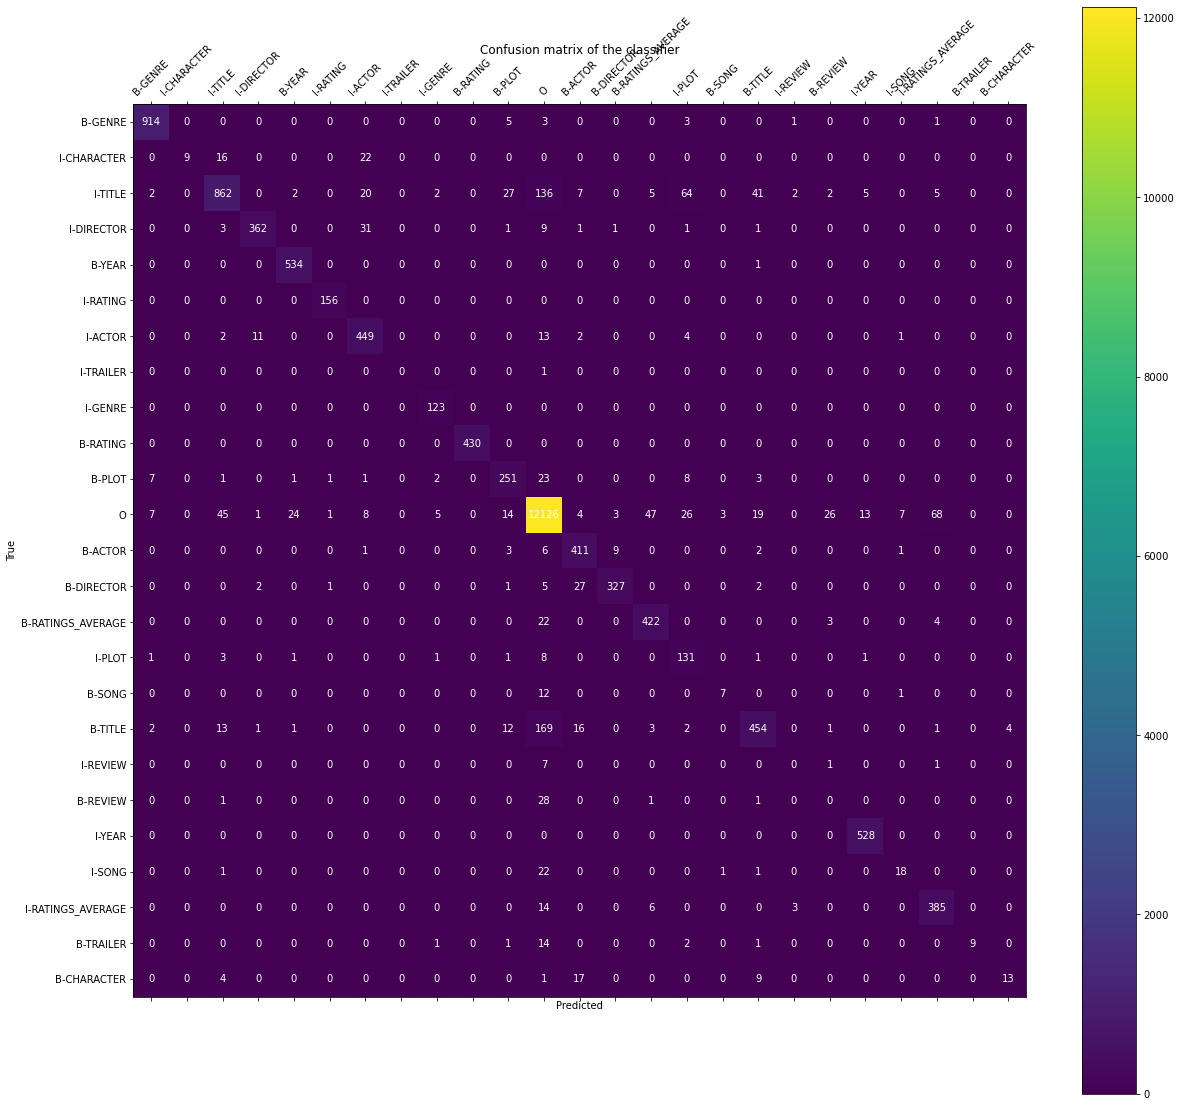

In [17]:
confusion_matrix_heatmap(y_test, preds)

In [ ]:
print("testing tagger...")
preds = []
y_test = []

#changed the lowest values as per the new classification report
lowest_precision = ['B-REVIEW', 'I-REVIEW','I-TRAILER']

for c in lowest_precision:
    class_counter = 0
    sent_count = 0
    print('For the class {}'.format(c))
    for sent in test_data:
        sent_count += 1
        sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y_test.extend(sent_true)

        #print out all the sentences where there is a false positive for that class 
        #(i.e. the label is predicted in the predicted label for a given word by the tagger, 
        #but this is not present in the corresponding ground truth label for that word)
        fp_counter =0
        fp =[]
        
        #for the sentence
        for i in range(0,len(sent_true)):
        #compare every bio tag of the sentence's word between truth and predicted sentece
        #if the predicted tag lies in the list of lowest precision then increase the counter
            if (sent_true[i] != sent_preds[i]) and (sent_preds[i] == c):
                #print(sent_true[i])
                #print(sent_preds[i])
                fp_counter +=1
        
        #if the counter for the sentence has more than 0 false positives, then print the ground truth and 
        # the respective false positive predicted
        if(fp_counter>0):
            print('Ground truth:')
            print(sent)
            print('False positive predicted:')
            for i in range(0,len(sent)):
                senti_sent_predsi = (sent[i][0],sent_preds[i])
                fp.append(senti_sent_predsi)
            class_counter +=1
            print(fp)
    print('Number of sentences having false positives for class {} is {}'.format(c,class_counter))
    print('Number of sentences parsed{}'.format(sent_count))
print("done")

In [ ]:
print("testing tagger...")
preds = []
y_test = []

#changed the lowest values as per the new classification report
lowest_recall = ['B-REVIEW','I-REVIEW','I-TRAILER','B-TRAILER','B-CHARACTER','I-CHARACTER']

for c in lowest_recall:
    class_counter = 0
    sent_count = 0
    print('For the class {}'.format(c))
    for sent in test_data:
        sent_count += 1
        sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds.extend(sent_preds)
        y_test.extend(sent_true)

        #print out all the sentences where there is a false negative for that label 
        #(i.e. the label is present in the ground truth label for a given word, 
        #but that label is not predicted for that word by the tagger)
        fn_counter =0
        fn =[]
        
        #for the sentence
        for i in range(0,len(sent_preds)):
        #compare every bio tag of the sentence's word between truth and predicted sentece
        #if the truth's tag lies in the list of lowest recall then increase the counter
            if (sent_true[i] != sent_preds[i]) and (sent_true[i] == c):
                #print(sent_true[i])
                #print(sent_preds[i])
                fn_counter +=1
                
        #if the counter for the sentence has more than 0 false negatives, then print the ground truth and 
        # the respective false negative predicted
        if(fn_counter>0):
            print('Ground truth:')
            print(sent)
            print('False negative predicted:')    
            for i in range(0,len(sent)):
                senti_sent_predsi = (sent[i][0],sent_preds[i])
                fn.append(senti_sent_predsi)
            print(fn)
            class_counter +=1
    print('Number of sentences having false negatives for class {} is {}'.format(c,class_counter))
    print('Number of sentences parsed {}'.format(sent_count))
print("done")

# 5. Feature experimentation for optimal macro average (20 marks).
#### The last part of the question to for report on the original test data

In [15]:
#re-train the model on ALL the training data

# prepare the whole training data data:
engtrain_train_data = get_raw_data_from_bio_file("engtrain.bio.txt") 
engtrain_data = [preProcess(example) for example in engtrain_train_data]
print(len(engtrain_data), "instances")
print(sum([len(engtrain_sent) for engtrain_sent in engtrain_data]), "words")

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(engtrain_data, TAGGER_PATH)
print("done")

9775 instances
99491 words
training tagger...
done


In [18]:
#print the classification report for the original test data 
#(i.e. from the test file engtest.bio.txt) as your final piece of code

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [19]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [20]:
# Output the classification report for engtest.bio.txt
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.90      0.94      0.92       812
      B-CHARACTER       0.79      0.46      0.58        90
       B-DIRECTOR       0.92      0.84      0.87       456
          B-GENRE       0.94      0.96      0.95      1117
           B-PLOT       0.72      0.67      0.69       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.92      0.88      0.90       451
         B-REVIEW       0.47      0.12      0.20        56
           B-SONG       0.80      0.52      0.63        54
          B-TITLE       0.79      0.80      0.80       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.96      0.95      0.95       720
          I-ACTOR       0.89      0.93      0.91       862
      I-CHARACTER       0.83      0.40      0.54        75
       I-DIRECTOR       0.91      0.83      0.87       496
          I-GENRE       0.87      0.71      0.78       